In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import sys
import typing
import gdal
import keras
import tensorflow as tf

from skimage import exposure

In [ ]:
%pip install git+https://github.com/karolzak/keras-unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/karolzak/keras-unet to /tmp/pip-req-build-2tknhapc
  Running command git clone -q https://github.com/karolzak/keras-unet /tmp/pip-req-build-2tknhapc
  Created wheel for keras-unet: filename=keras_unet-0.1.2-py3-none-any.whl size=17008 sha256=5e50d65cda1a80106def6ad5a4a7164555943bab55dc3ad6682dd27e879a4444
  Stored in directory: /tmp/pip-ephem-wheel-cache-ms2hmcry/wheels/ca/e1/e8/61638b7e082fcc34cf9b3e6ebf1fb852db0d19a1555b8aa13d
Successfully built keras-unet


In [ ]:
from google.colab import drive

# Setting up the drive paths 

Legend is given as 1 for the pixels other than boundaries and 2 for boundaries

In [ ]:
base_path = "/content/drive/My Drive/field_delineation"
input_path = base_path + "/data/"
output_path = base_path + "/networks"
image_path = "/Original"
label_path = "/Classified"

include_folders = ["Flevoland", "Friesland", "Gelderland", "Limburg", "Overijssel", "Zeeland", "Zuid-Holland"]

LEGEND = {1:'Other',2:'Field Boundary'}

Defining the function to read the file names and replace it with only province and index

In [ ]:
def key_gen(file_name):
  file_name = file_name.lower()
  file_name = file_name.replace("classified_","")
  file_name = file_name.replace("original_","")
  file_name = file_name.replace(".tif","")
  (province,index) = tuple(file_name.split("_"))
  index = int(index)
  return (province, index)

# Defining a function to convert the geotiffs to array formats

In [ ]:
def gtiff_to_array(file_path):
  data = gdal.Open(file_path)

  # The getrasterband will take all the bands from tiff file depending on the number of bands available
  bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]

  # np.stack will stack the bands in array format one after the other
  return np.stack(bands, axis=2)

# This function will take the classification as input and create a 2d array out of it.

In [ ]:
# The image is such way that it contains the black and white pixels for boundaries.

def transform_classification_image(input):

  # The maximum value will be of 255 for boundaries and 0 for non boundaries.
  result = np.reshape(np.max(input,axis =2),(input.shape[0],input.shape[1],1))

  # Each pixel with a value of 0 will be assigned a value of 1 and 255 will be assigned 2
  result = np.where(result>0,2,1)
  
  return result

In [ ]:
# Creating blank dictionaries to save the image and classification pixels
images = {}
labels = {}

for folder in include_folders:
  original = input_path + folder + image_path
  classified = input_path + folder + label_path

  for f in os.listdir(original):
    value = gtiff_to_array(original + "/" + f)
    key = key_gen(f)
    images[key] = value

  for f in os.listdir(classified):
    value = gtiff_to_array(classified + "/" + f)
    value = transform_classification_image(value)
    key = key_gen(f)
    labels[key] = value
    
  print(f"{folder} image tiles : {len(os.listdir(original))}")
  print(f"{folder} label tiles: {len(os.listdir(classified))}")

# Value of the dictionary will be the pixels and the keys are province name
print(f"Shape of sample image file: {list(images.values())[0].shape}")
print(f"Shape of sample label file: {list(labels.values())[0].shape}")

print(f"Total number of image tiles: {len(images)}")

Flevoland image tiles : 19
Flevoland label tiles: 19
Friesland image tiles : 24
Friesland label tiles: 24
Gelderland image tiles : 3
Gelderland label tiles: 3
Limburg image tiles : 5
Limburg label tiles: 5
Overijssel image tiles : 36
Overijssel label tiles: 36
Zeeland image tiles : 32
Zeeland label tiles: 32
Zuid-Holland image tiles : 3
Zuid-Holland label tiles: 3
Shape of sample image file: (800, 800, 4)
Shape of sample label file: (800, 800, 1)
Total number of image tiles: 122


# Normalizing the pixel values between 0 and 1 for easy prediction

In [ ]:
def normalize(val,min,max):
  return (val-min)/(max-min)

# Using the formula of ndvi we define the normalize function
# normalize_array function which will take the 3d arrays as input and iterate over bands and normalize them one by one.

def normalize_array(arr):

  # np.zeros will set array with zeros in the form of image shape (800*800)
  arr_norm = np.zeros(arr.shape,dtype=np.float32)
  
  # The for loop will take in range all the bands in the images and compute the minimum and the maximum of 
  # those image bands and store it in 'arr_norm' as normalized pixel values.
  for i in range(arr.shape[2]):
    min = arr[:,:,i].min()
    max = arr[:,:,i].max()
    arr_norm = (arr - min)/(max - min)
  return arr_norm

# k will take all the images from images dictionary and noramlize it accordingly by taking the same image through v.
for k,v in images.items():
  images[k] = normalize_array(v)
  print(f"Normalized {k[0]}_{k[1]}")

Normalized flevoland_93
Normalized flevoland_20
Normalized flevoland_95
Normalized flevoland_107
Normalized flevoland_94
Normalized flevoland_22
Normalized flevoland_108
Normalized flevoland_79
Normalized flevoland_37
Normalized flevoland_50
Normalized flevoland_64
Normalized flevoland_21
Normalized flevoland_51
Normalized flevoland_65
Normalized flevoland_36
Normalized flevoland_34
Normalized flevoland_66
Normalized flevoland_80
Normalized flevoland_52
Normalized friesland_180
Normalized friesland_179
Normalized friesland_135
Normalized friesland_148
Normalized friesland_195
Normalized friesland_152
Normalized friesland_151
Normalized friesland_166
Normalized friesland_138
Normalized friesland_177
Normalized friesland_136
Normalized friesland_162
Normalized friesland_178
Normalized friesland_175
Normalized friesland_161
Normalized friesland_123
Normalized friesland_134
Normalized friesland_163
Normalized friesland_137
Normalized friesland_150
Normalized friesland_176
Normalized friesl

#Splitting the data into training and testing sets


In [ ]:
import random
seed = 34
relative_train_size = 0.9

def calculate_k(n):
  k = relative_train_size *n
  return int(k)

# We will create a random generator A funtion to calculate the k
random_gen = random.Random(seed)

# We will extract all the keys from the image dictionary
keys = set(images.keys())

# Then we will split the keys set into training and testing keys
# The keys_train' variable stores the random sample from the images dictionary by using the sample(sequence, sampling_size) function, 
# in our case the sequence is keys from images dict and sampling size is 90 percent of images.

keys_train = set(random_gen.sample(keys,calculate_k(len(keys))))
keys_test = keys - keys_train


# Now the y_train variable will also have the same keys in labels as in images so it will store the corresponding classification labels
# If k is 0 then it will pickup the corresponding value from keys_train and the same value will be chosen from images dict as the province name is same 
# and it will be inputed into the x_train_dict as key and its corresponding value will be stored.

x_train_dict = {k : images[k] for k in keys_train}
y_train_dict = {k : labels[k] for k in keys_train}

# k in the top is different it will give the percent of split wheres k in the bottom part is just an iterator
x_test_dict = {k : images[k] for k in keys_test}
y_test_dict = {k : labels[k] for k in keys_test}

print(x_train_dict.keys())
print(x_test_dict.keys())
print(y_train_dict.keys())

dict_keys([('overijssel', 21), ('friesland', 175), ('overijssel', 2), ('flevoland', 21), ('flevoland', 66), ('overijssel', 46), ('zuid-holland', 114), ('friesland', 134), ('zeeland', 4), ('overijssel', 74), ('overijssel', 5), ('overijssel', 71), ('friesland', 136), ('overijssel', 33), ('overijssel', 30), ('friesland', 150), ('zeeland', 20), ('friesland', 161), ('zeeland', 33), ('friesland', 195), ('friesland', 152), ('overijssel', 17), ('zeeland', 10), ('overijssel', 14), ('limburg', 82), ('zeeland', 76), ('zeeland', 23), ('flevoland', 94), ('friesland', 166), ('zeeland', 36), ('friesland', 177), ('zeeland', 49), ('zeeland', 62), ('overijssel', 20), ('zuid-holland', 100), ('flevoland', 80), ('overijssel', 1), ('flevoland', 22), ('overijssel', 45), ('limburg', 165), ('friesland', 135), ('zeeland', 3), ('gelderland', 29), ('overijssel', 4), ('flevoland', 64), ('overijssel', 70), ('friesland', 137), ('overijssel', 32), ('overijssel', 98), ('overijssel', 29), ('zeeland', 6), ('flevoland', 

# Visualizing sample data

The visualize labels function takes in the array, title and legend_labels

fig.add_subplot makes the 1 by 1 grid of plot


values variable will take the unique values by converting the 3d array to 1d array through ravel


imshow will show the array values as image


colors will store the unique colors based on values by also normalizing it


The first for loop will enumerate through the values which contain 1 and 2 these values will go into to label and get labelled accordingly


the first list of colors will contain the pixel values for the "other" and the second one will contain the "boundary"

the pyplot legend will just plot the legend values by adding the 2 patches in the figure accordingly

param arr: Input image (4 bands, the first 3 will be printed)
param title: Title of the plot
Switching bands:
blue green red
red  green blue

the for loop will perform stretching for better visualization

the key will choose the first value pf x_train_dict which was generated randomly

it will take its corresponding values to input it as 3d array into the functions

([(0.267004, 0.004874, 0.329415, 1.0), (0.993248, 0.906157, 0.143936, 1.0)],
 array([1, 2]),
  <matplotlib.patches.Patch at 0x7fc9f4a7e410>])

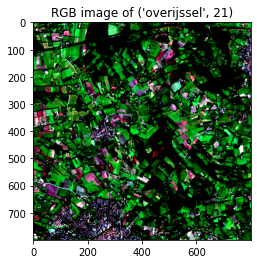

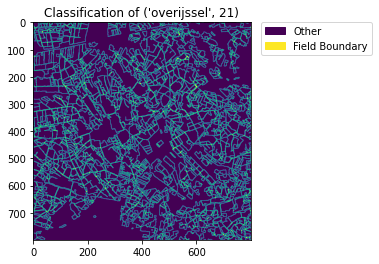

In [ ]:
from matplotlib import patches, pyplot

def visualize_labels(arr,title,legend_labels):

  # The visualize labels function takes in the array, title and legend_labels
  
  fig = pyplot.figure()
  a = fig.add_subplot(1,1,1)
  a.set_title(title)

  values = np.unique(arr.ravel())
  im = pyplot.imshow(arr[:,:,0])

  colors = [im.cmap(im.norm(v)) for v in values]

  legend = []
  for i,v in enumerate(values):
    legend.append(patches.Patch(color = colors[i],
                                label = legend_labels[v]))
    
  pyplot.legend(handles = legend, bbox_to_anchor = (1.05,1), 
                loc = 2, borderaxespad = 0.)
  return colors, values, legend

def visualize_data(arr,title):
  data = arr[:,:,0:-1]
  red = data[:,:,0].copy()
  data[:,:,0] = data[:,:,2]
  data [:,:,2] = red

  data = data.astype(np.float32)

  for i in range(data.shape[2]):
    p2,p98 = np.percentile(data[:,:,i], (2,98))
    data[:,:,i] = exposure.rescale_intensity(data[:,:,i], in_range = (p2,p98))

  fig = pyplot.figure()
  a= fig.add_subplot(1,1,1)
  a.set_title(title)
  pyplot.imshow(data)

key = list(x_train_dict.keys())[0]
visualize_data(images[key], f"RGB image of {key}")

visualize_labels(labels[key], f"Classification of {key}",LEGEND)

# Making patches of smaller size

The function gridwise_sampling will take input array as 3d and return a 4d array where the last dimension consists of patches out of the image.

We are setting the patchsize of 200*200 pixels

The input parameters of this function are 3d array of the image and the patchsize.

The x variable will save the no of image tiles by dividing the pixels with patchsize

n will store the number of bands available

making a patches object to store a empty skeleton of image type array

the for loop will go over all the columns and rows in the image from 0 to 200 which is the size of the patch. It will keep making for 4 patches horizontally and 4 in vertical direction giving a total of 16 patches of size 200*200

np.expand will give the entire dimension of the array

the second for loop will just iterate for the images stored in x_train_dict. It will pass the array values of image through the gridwise sampling function to convert all the images into small patches. Similarly for the y_train_dict.

the while loop will take the sampling size from the x_train and just visualize it according to the functions defined above

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


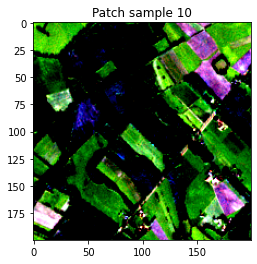

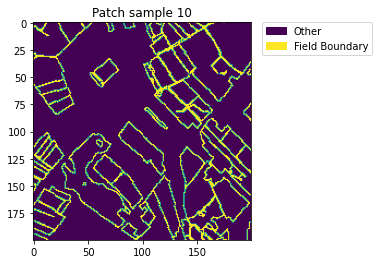

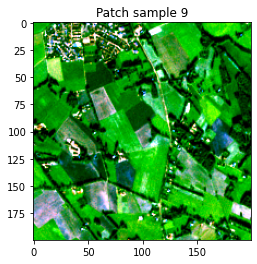

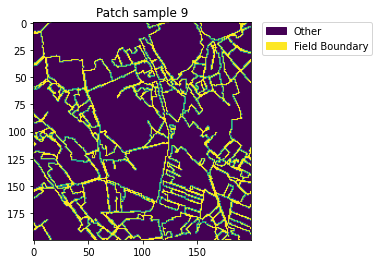

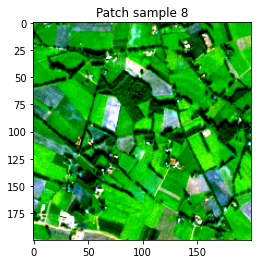

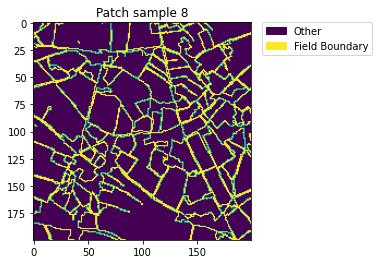

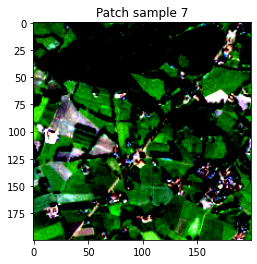

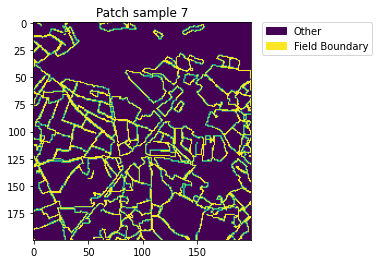

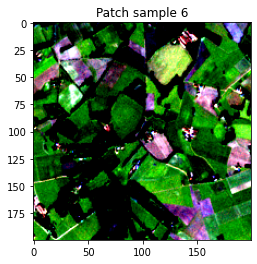

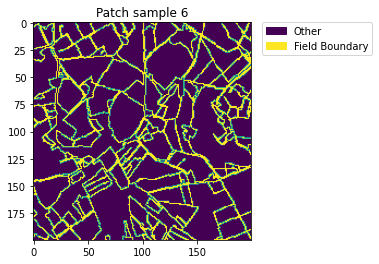

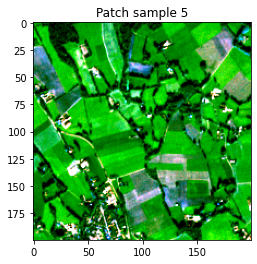

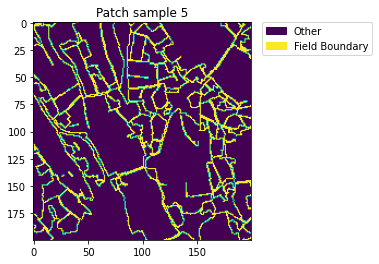

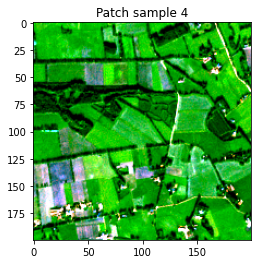

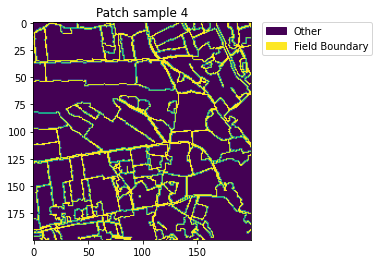

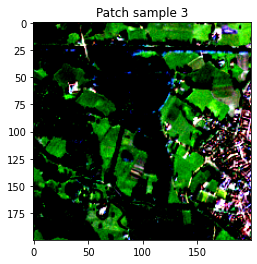

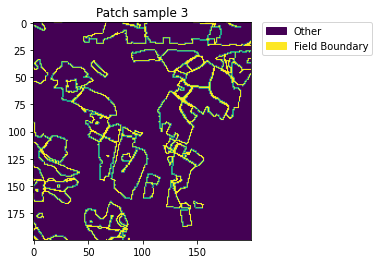

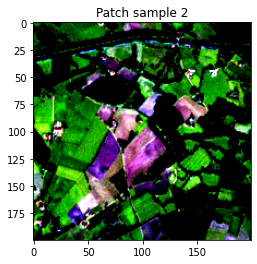

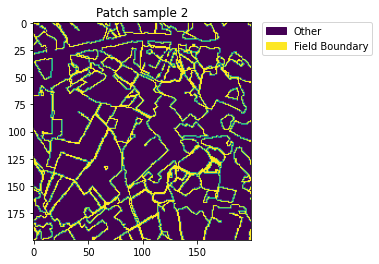

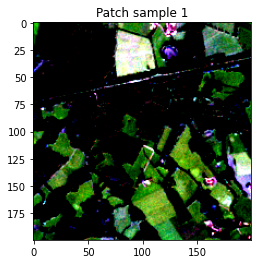

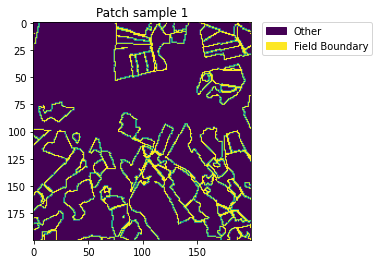

In [ ]:
PATCHSIZE = 200
NBANDS = list(images.values())[0].shape[-1]

def gridwise_sampling(img,patchsize):
  x = int(img.shape[0] / patchsize)
  y = int(img.shape[1] / patchsize)
  n = img.shape[2]
  s = patchsize

  patches = np.zeros(shape = (0,s,s,n), dtype = img.dtype)

  for row in range(x):
    for col in range(y):
      patch = img[row * s : (row + 1) * s, col * s : (col + 1) * s, :]
      patch = np.expand_dims(patch, axis=0)
      patches = np.concatenate((patches,patch),axis = 0)
  return patches

x_train = np.zeros(shape = (0,PATCHSIZE, PATCHSIZE, NBANDS),dtype = np.float32)
y_train = np.zeros(shape = (0, PATCHSIZE,PATCHSIZE,1),dtype = np.int)

for k in x_train_dict.keys():
  x_patches = gridwise_sampling(x_train_dict[k], PATCHSIZE)
  y_patches = gridwise_sampling(y_train_dict[k], PATCHSIZE)

  x_train = np.concatenate((x_train, x_patches), axis = 0)
  y_train = np.concatenate((y_train,y_patches), axis =0)

sample_size = 10

while sample_size:
  visualize_data(x_train[sample_size], f"Patch sample {sample_size}")
  visualize_labels(y_train[sample_size], f"Patch sample {sample_size}", LEGEND)
  sample_size -= 1

In [ ]:
print(x_train.shape[1])
print(y_train.shape[1])
print(x_train.shape[2])

200
200
200


In [ ]:
import imp, h5py
import dill, pickle
imp.reload(h5py)

import tensorflow as tf
from tensorflow.python.keras import backend as K
sess = K.get_session()

from tensorflow.compat.v1.keras.backend import set_session

# Setting up the neural network

First we will be configuring the model and also the gpu memory allocation in line 2

Then moving on to defining the function for converting the ground truth data to one hot encoding

The data structure is 4d, the classification image will be split into 2 classes, other and boundary.

One hot encoding will make sure that only correct labels are activated for both the classes.

Y will store the numpy array based on the input array shapes. 

nc is just the number of classes

np.where will perform the one hot encoding, by putting '1' if the condition is satisfied and '0' if the condition is not satisfied.

Train function will build the neural network for training purpose and accept the following variables as described.

Then we go onto defining some functions which will help in importing and exporting of the network, its weights and model history

Model history class will act as a container class to store the information of trained model

The ModelHist class with the init function will initiate the objects based on the object parameters. It will do the job of storing all the model parameters once the model is trained and will be used by the export_model function to access the parameters such as uuid and name of the model.

The get file names will just give the names to the different files in order. The export function will choose the raw files and assign them names accordingly.For eg if the weights are to be stored then it will acces the model weights through m.model.save_weights and pass the file name for it.

The import_model will acces the files accordong to the name and use keras' model.load_model function to load the files.

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config = config))

# helper functions
def to_categorical_4d(y: np.ndarray, nc: int):
  Y = np.zeros((y.shape[0], y.shape[1], y.shape[2], nc), dtype = np.int)

  Y[:,:,:,0] = np.where(y[:,:,:,0] == 1,1,0)

  Y[:,:,:,1] = np.where(y[:,:,:,0] == 2,1,0)

  return Y

def train(model, data: np.ndarray, labels: np.ndarray, epochs:int, 
          batch_size: int = 64, validation_split : float = 0.01, verbosity: int = 2):
  
  history = model.fit(x = data, y = labels, batch_size = batch_size,
                      epochs = epochs, verbose = verbosity,
                      validation_split = validation_split)
  return history

class ModelHist:
  def __init__(self, uuid, name, model, history, readme):
    self.uuid = uuid
    self.name = name
    self.model = model
    self.history = history
    self.readme = readme
  

def get_file_names(uuid, name):

  base = f"{output_path}/{str(uuid)}-{name}"
  f_readme = f"{base}-readme.txt"
  f_model = f"{base}-model.h5"
  f_weights = f"{base}-weights.h5"
  f_history = f"{base}-history"

  return (f_readme, f_model, f_weights, f_history)


def export_model(m:ModelHist):
  f_readme, f_model, f_weights, f_history = get_file_names(m.uuid, m.name)

  with open(f_readme, 'w') as f:
    f.write(m.readme)
  print(f"Exported history: {f_history}")

  m.model.save(f_model)
  print(f"Exported model: {f_model}")

  m.model.save_weights(f_weights)
  print(f"Exported weights: {f_weights}")

  with open (f_history,"wb") as f:
    pickle.dump(m.history, f)
  print(f"Exported history: {f_history}")


def import_model(uuid, name):
  f_readme, f_model, f_weights, f_history = get_file_names(uuid, name)

  with open(f_readme, 'r') as f:
    readme = "".join(f.readlines())
  print(f"Imported Readme: {f_readme}")

  model = tf.keras.models.load_model(f_model)
  print(f"Imported model: {f_model}")

  model.load_weights(f_weights)
  print(f"Imported weights: ({f_weights}")

  with open(f_history,'rb') as f:
    history = pickle.load(f)
  print(f"Imported History: {f_history}")

  return ModelHist(uuid, name, model, history, readme)

# Network enhancement

Building a dynamic function for the fast convolutional network

x: the number of rows in the image

y: the number of cols in the image

bands: no of bands in the image

labels: no of classes

layers: no of layers we want to include in the network



In [ ]:
from keras.layers import Activation, BatchNormalization, Convolution2D, LeakyReLU, Reshape, ZeroPadding2D
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from keras_unet.models import satellite_unet


def build_unet(x: int, y: int, bands: int, labels: int, layers: int =2,) -> tf.keras.Model:
  model = satellite_unet(input_shape = (x,y,bands), 
                         num_classes = labels,
                         output_activation = "softmax", 
                         num_layers = layers)
  return model


def build_unet2(x:int, y:int, bands: int, labels:int,) -> tf.keras.Model:
  return build_unet(x, y, bands, labels, layers = 2)


def build_unet3(x:int, y:int, bands:int, labels:int,):
  return build_unet(x,y,bands,labels, layers = 3)

def build_fcndk(x:int, y:int, bands:int, labels: int, layers = 4,) -> tf.keras.Model:
  model = keras.models.Sequential()
  model.add(ZeroPadding2D((2,2), input_shape = (x,y,bands)))
  model.add(Convolution2D(filters = 16, 
                          kernel_size = (5,5), 
                          dilation_rate = (1,1)))
  model.add(BatchNormalization(axis = 3))
  model.add(LeakyReLU(0.1))

  if layers >= 5:
    # FCNDK5
     model.add(ZeroPadding2D((10, 10)))
     model.add(Convolution2D( filters=32,
                             kernel_size=(5, 5),
                             dilation_rate=(5, 5)))
     
     model.add(BatchNormalization(axis=3))
     model.add(LeakyReLU(0.1))

  if layers >= 6:
    # FCNDK6
    model.add(ZeroPadding2D((12, 12)))
    model.add(Convolution2D( filters=32,
                            kernel_size=(5, 5),
                            dilation_rate=(6, 6)))
    
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
  
  # output layer
  model.add(Convolution2D (filters = labels,
                           kernel_size = (1,1)))
  model.add(keras.layers.Activation(activation = "softmax"))
  return model

def build_fcndk5(x:int, y:int, bands: int, labels: int,) -> tf.keras.Model:
  return build_fcndk(x,y,bands,labels, layers = 5)

def build_fcndk6(x:int, y:int, bands: int, labels: int,) -> tf.keras.Model:
  return build_fcndk(x,y,bands,labels, layers = 6)


def build_network(name:str)-> typing.Callable:

  if name.lower() == "fcndk5":
    return build_fcndk5
  elif name.lower() == "fcndk6":
    return build_fcndk6
  elif name.lower() == "unet2":
    return build_unet2
  elif name.lower() == "unet3":
    return build_unet3

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
import uuid

SKIP = 0
TRAIN_NEW = 1
LOAD_AND_TRAIN = 2
LOAD = 3

NUMBER_BANDS = 4
NUMBER_CLASSES = 2

NETWORK_UUID = str(uuid.uuid1())

# Setting up the important parameters for the network

In [ ]:
# configuring the execution mode for the network execution
# in this case we are training the new model
# in case we want to load and train then we can choose the respective options as defined above
exec_mode = LOAD

# if we choose to train from the existing model then we need to specify these parameters
load_from_uuid = "22f7adf6-f864-11ec-be5e-0242ac1c0002"
load_from_name = "unet3"

# for saving the training configuration after the training is completed
SAVE_AFTER_EXEC = True

# specifying the network name we want to train - takes the value of any fcndk and unet
NETWORK_NAME = "unet3"

# the number of iterations through data that we want to allow
# larger number of epochs may give good accuracy but risks to overfit the data
NUMBER_EPOCHS = 800

BATCH_SIZE = 8

# the fraction of data that we want to use for validation
VALIDATION_SPLIT = 0.05

# choosing the network optimizer - accepted values are SGD and Adam
NETWORK_OPTIMIZER = "Adam"

# hyperparamters for sgd optimizer
SGD_LEARNING_RATE = 0.01
SGD_MOMENTUM = 0.9

# hyperparameters for adam optimizer
ADAM_LEARNING_RATE = 0.0015
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999
ADAM_EPSILON = 1e-06

# Setting up the Execution modes

The model_builder object stores the network and by accessing the build_network function which is a wrapper function for building different types of neural network.

Then I set up the readme file based on the parameters provided for the network

Moving on to setting up some if and else conditions according to the network name provided. 

the first condition takes the network optimization mode as train new and builds the model by accessing the build network function link and after which compilation of model takes place

.compile() function from keras adds important parameters for wrapping up the model which makes the model ready to train

the second condition just loads the network

then we train the network only for train_new and load_and_train modes

if save after execution parameter is given as true then the model will be saved by export_model function

In [ ]:
model_builder = build_network(NETWORK_NAME)

if exec_mode in [LOAD, LOAD_AND_TRAIN]:
  NETWORK_UUID = load_from_uuid
  NETWORK_NAME = load_from_name

readme = f""" 
Training Config
-------------------------------------
NETWORK
  Uuid:               {NETWORK_UUID}
  Name:               {NETWORK_NAME}
  Optimizer:          {NETWORK_OPTIMIZER}


PARAMETERS
  Bands:              {NUMBER_BANDS}
  Classes:            {NUMBER_CLASSES}
  Epochs:             {NUMBER_EPOCHS}
  Batch Size:         {BATCH_SIZE}
"""

if  NETWORK_OPTIMIZER == "SGD":
  readme += f"""
OPTIMIZER (SGD)
  Learning Rate:    {SGD_LEARNING_RATE}
  Momentum:         {SGD_MOMENTUM}
  """

if NETWORK_OPTIMIZER == "Adam":
  readme += f"""
OPTIMIZER (Adam)
  Learning Rate:    {ADAM_LEARNING_RATE}
  Beta1:            {ADAM_BETA_1}
  Beta2:            {ADAM_BETA_2}
  Epsilon:          {ADAM_EPSILON}
  """

readme += f"""
EXECUTION SUMMARY
  Patches:          {x_train.shape[0]}
  Validation Split: {VALIDATION_SPLIT}
  Resolution:       {x_train.shape[1]}x{x_train.shape[2]}
  Bands:            {x_train.shape[3]}
  Classes:          {y_train.shape[3]}
  """

readme+= "\n"
readme+= "Training Set:\n     "
readme+= "\n    ".join([f"({k[0]}, {k[1]})" for k in x_train_dict.keys()])

readme+= "\n"
readme+= "Test set:\n         "
readme+= "\n    ".join([f"({k[0]}, {k[1]})" for k in x_test_dict.keys()])

if NETWORK_OPTIMIZER == "Adam":
  OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = ADAM_LEARNING_RATE,
                                       beta_1 = ADAM_BETA_1,
                                       beta_2 = ADAM_BETA_2,
                                       epsilon = ADAM_EPSILON)
elif NETWORK_OPTIMIZER == "SGD":
  OPTIMIZER = tf.keras.optimizers.SGD(learning_rate = SGD_LEARNING_RATE,
                                      momentum = SGD_MOMENTUM)
  
if exec_mode in [TRAIN_NEW]:
  print(f"Built a new network: {NETWORK_UUID} {NETWORK_NAME}")
  model = model_builder(x_train.shape[1], x_train.shape[2], NUMBER_BANDS, NUMBER_CLASSES)
  model.compile(optimizer = OPTIMIZER, loss = 'binary_crossentropy',
                metrics = 'accuracy')
  
if exec_mode in [LOAD, LOAD_AND_TRAIN]:
  print(f"Loaded the existing network: {NETWORK_UUID} {NETWORK_NAME}")
  m = import_model(NETWORK_UUID, NETWORK_NAME)
  readme = m.readme
  model = m.model
  history = m.history

print(readme)

if exec_mode in [TRAIN_NEW, LOAD_AND_TRAIN]:
  y_train = to_categorical_4d(y_train, NUMBER_CLASSES)
  history = train(model, x_train, y_train, NUMBER_EPOCHS, 
                  batch_size = BATCH_SIZE, 
                  validation_split = VALIDATION_SPLIT).history

if exec_mode in [TRAIN_NEW, LOAD, LOAD_AND_TRAIN]:
  if SAVE_AFTER_EXEC:
    export_model(ModelHist(NETWORK_UUID, NETWORK_NAME, model, history, readme))

if exec_mode in [SKIP]:
  print("Remark: Execution mode is chosen as skip, Nothing will be executed")

Loaded the existing network: 22f7adf6-f864-11ec-be5e-0242ac1c0002 unet3
Imported Readme: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-readme.txt
Imported model: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-model.h5
Imported weights: (/content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-weights.h5
Imported History: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-history
 
Training Config
-------------------------------------
NETWORK
  Uuid:               22f7adf6-f864-11ec-be5e-0242ac1c0002
  Name:               unet3
  Optimizer:          Adam


PARAMETERS
  Bands:              4
  Classes:            2
  Epochs:             800
  Batch Size:         8

OPTIMIZER (Adam)
  Learning Rate:    0.0015
  Beta1:            0.9
  Beta2:            0.999
  Epsilon:          1e-06
  
EXECUTION SUMMARY
  Patches:  

# Visualizing Plots for training and accuracy

the generate_plot function will take in metrics and title as input and gives the plot for respective metrics

in the first mention we will access the loss from model history and plot it

in the second mention we will access the accuracy from model history

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def generate_plot(metric1, metric2, title: str):
  if title is None:
    title = p

  # Create figure with secondary y-axis
  fig1 = make_subplots(specs=[[{"secondary_y": True}]])
  # Add traces
  fig1.add_trace(go.Scatter(y=metric1, name="Loss"),
                 secondary_y=False)

  fig1.add_trace(go.Scatter(y=metric2, name="Accuracy"),
                 secondary_y=True)

  fig1.update_layout(title=f"Graph of {title} loss and {title} accuracy",title_x=0.50)
  fig1.update_xaxes(title_text="Epochs")
  fig1.update_yaxes(title_text="Loss", secondary_y = False)
  fig1.update_yaxes(title_text="Accuracy", secondary_y = True)
  fig1.update(layout_coloraxis_showscale = True)
  fig1.update_layout(height = 800)
  fig1.update_layout(hovermode="x unified")

  fig1.show()

generate_plot(history["loss"],history["accuracy"],"Training")
generate_plot(history["val_loss"], history["val_accuracy"], "Validation")